<a href="https://colab.research.google.com/github/FajarRamadhanBBX/Perhitungan-surat-suara-Pemilu-2024-menggunakan-OMR/blob/main/Deteksi_hasil_surat_suara_pemilu_2024_melalui_OMR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import library

In [19]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Memuat citra yang digunakan

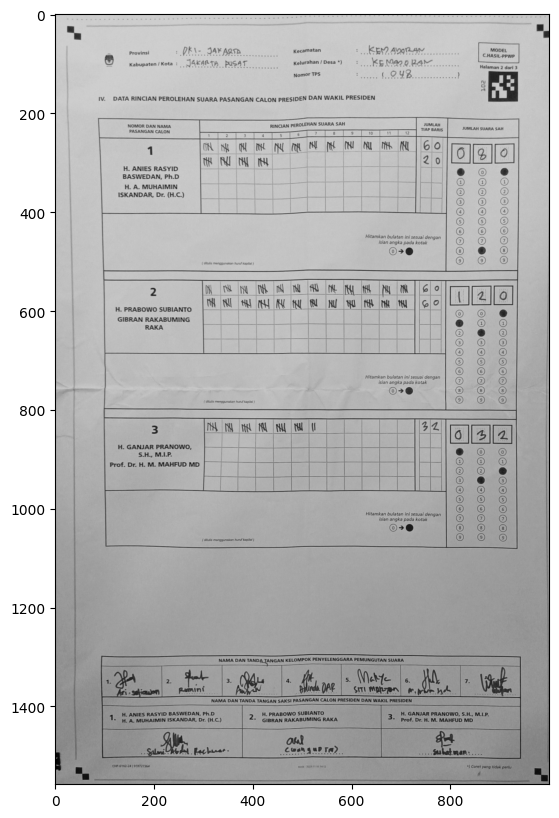

In [20]:
image = cv2.imread('/content/surat-suara.jpg', 0)
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Pra proses citra

## Gaussian Blur dan Histogram Equalization

Gaussian blur merupakan salah satu teknik dalam pemrosesan citra digital yang digunakan untuk menghaluskan citra yang memanfaatkan konsep konvolusi.

Histogram Equalization atau perataan histogram merupakan suatu teknik untuk meningkatkan kontras citra dengan cara menyeimbangkan distribusi intensitas dari suatu citra.

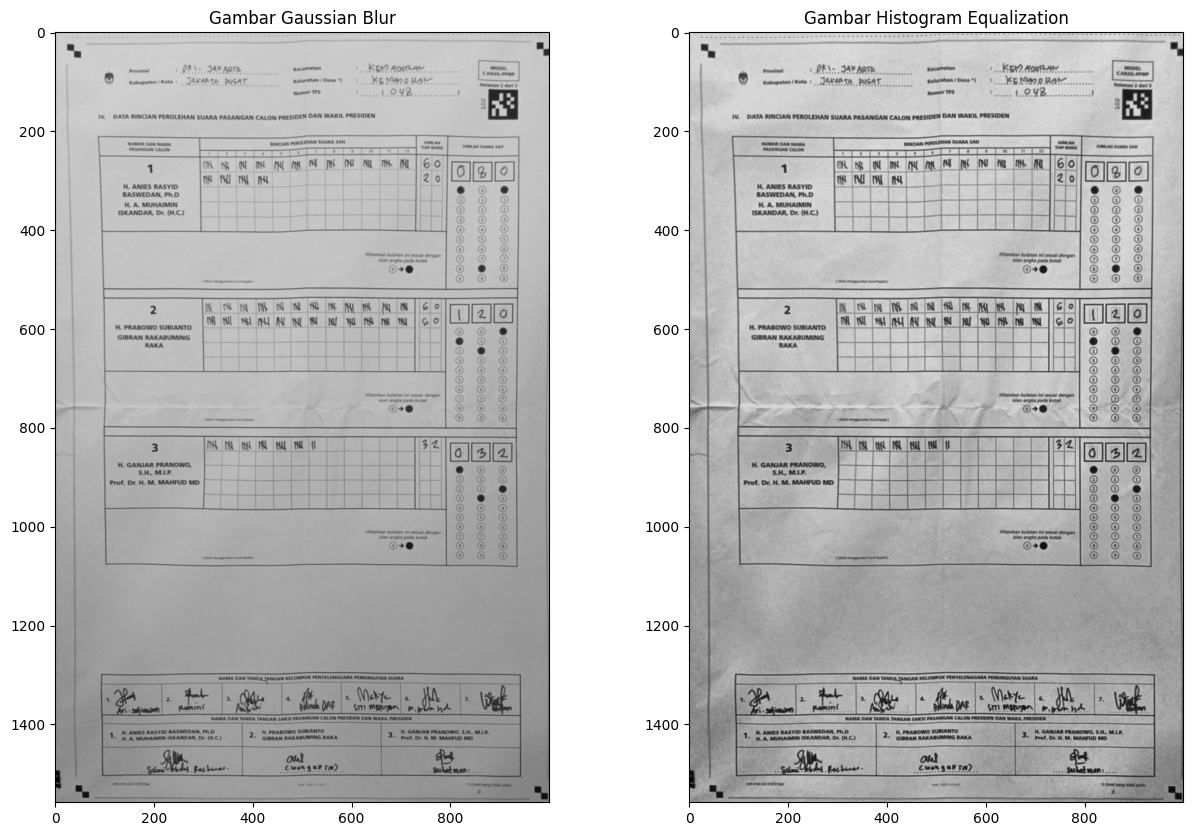

In [21]:
gray_image = cv2.GaussianBlur(image, (3, 3), 0)

clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(11,11))
equalized = clahe.apply(gray_image)

plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(gray_image, cv2.COLOR_BGR2RGB))
plt.title('Gambar Gaussian Blur')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(equalized, cv2.COLOR_BGR2RGB))
plt.title('Gambar Histogram Equalization')

plt.show()

In [22]:
print(equalized.shape)

(1558, 1000)


## Transformasi Perspektif

Transformasi perspektif merupakan teknik yang digunakan untuk sudut pandang suatu citra, sehingga citra yang diproses menjadi rapih dan dapat di proses lebih lanjut.

In [23]:
pt1 = np.float32([[90,210],[936,211],[103,1076],[934,1080]])
pts2 = np.float32([[0,0],[equalized.shape[1],0],[0,equalized.shape[0]],[equalized.shape[1],equalized.shape[0]]])

for val in pt1:
  equalized = cv2.circle(equalized,(int(val[0]), int(val[1])),20,(0,255,0), 8)

M = cv2.getPerspectiveTransform(pt1,pts2)
dst = cv2.warpPerspective(equalized,M,(equalized.shape[1],equalized.shape[0]))

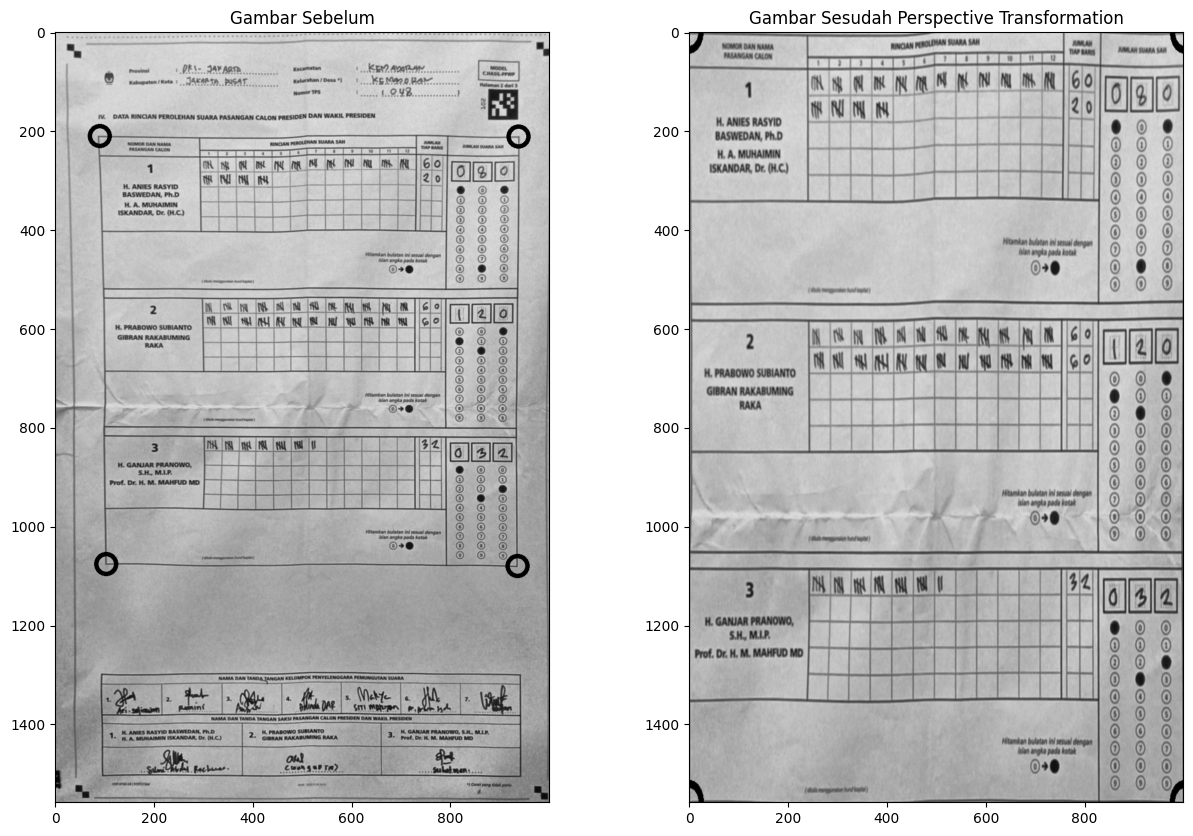

In [24]:
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(equalized, cv2.COLOR_BGR2RGB))
plt.title('Gambar Sebelum')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.title('Gambar Sesudah Perspective Transformation')

plt.show()

## Menajamkan citra

Proses penajaman citra merupakan proses yang berguna untuk menajamkan citra dengan cara menonjolkan detail dan tepi objek.

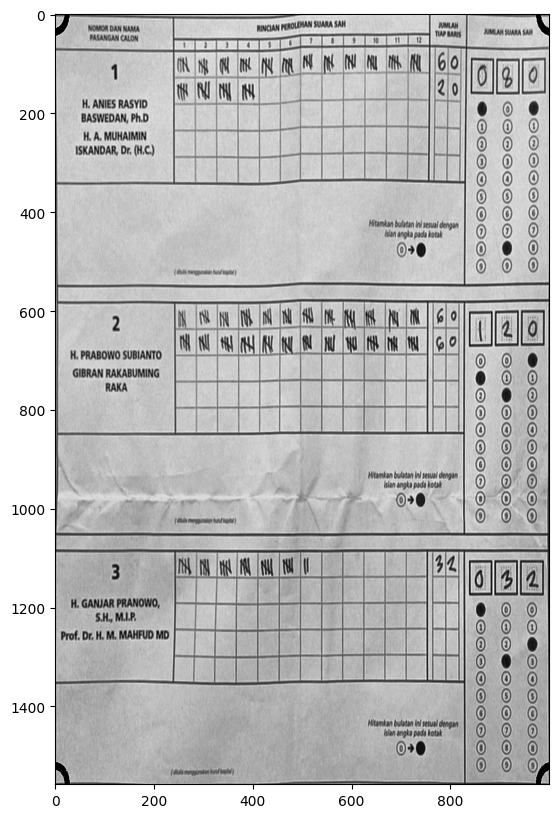

In [25]:
kernelSharpen = np.array([[0, -1, 0],
                          [-1, 5,-1],
                          [0, -1, 0]])
image_sharp = cv2.filter2D(src=dst, ddepth=-1, kernel=kernelSharpen)

plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(image_sharp, cv2.COLOR_BGR2RGB))

## Mengambil RoI (Region of Interest)

Region of Interest merupakan bagian citra yang akan digunakan untuk diproses lebih lanjut.

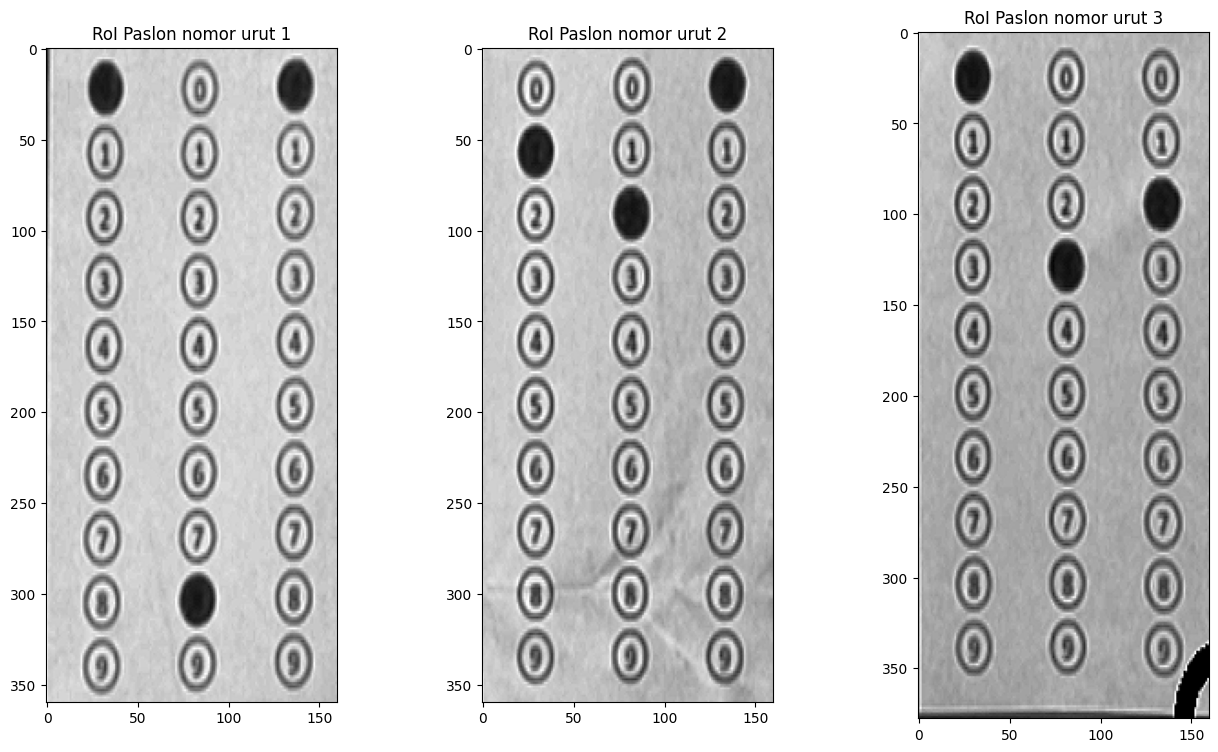

In [26]:
calon1 = image_sharp[170:530, 830:990]
calon2 = image_sharp[680:1040, 830:990]
calon3 = image_sharp[1180:, 830:990]

plt.figure(figsize=(15, 15))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(calon1, cv2.COLOR_BGR2RGB))
plt.title('RoI Paslon nomor urut 1')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(calon2, cv2.COLOR_BGR2RGB))
plt.title('RoI Paslon nomor urut 2')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(calon3, cv2.COLOR_BGR2RGB))
plt.title('RoI Paslon nomor urut 3')

plt.subplots_adjust(wspace=0.5)
plt.show()

# OMR (Optical Mark Recognition)

## Fungsi untuk mengubah format gambar agar dapat di proses

In [27]:
def preprocess_image(image):
    _, thresh = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV)
    return thresh

## Fungsi untuk menemukan contour pada gambar

Dalam hal ini, contour merupakan kumupulan piksel yang membentuk suatu bulatan yang digunakan untuk menandai hasil perhitungan tiap satuan.

In [28]:
def find_contours(thresh):
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

## Fungsi untuk menandai tiap bulatan

Contour yang membentuk bulatan ditandai menjadi suatu persegi agar dapat diproses dengan mudah

In [29]:
def marking_contour(image, contours, min_area=100):
    obj = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > min_area:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
            obj.append((x, y, w, h))
    return image, obj

## Fungsi untuk mengurutkan bulatan dari paling atas

Pada proses sebelumnya, daftar bulatan yang ditandai menjadi persegi masih tidak berurut, maka dari itu harus diurutkan terlebih dahulu agar proses OMR dapat berjalan dengan sesuai.

In [30]:
def sort_contour(list_contour):
  sorted_cont = sorted(list_contour, key=lambda x: x[1])
  return sorted_cont

## Fungsi untuk membagi bulatan per satuan (kolom)

Urutan dari bulatan yang ada yaitu dari atas ke bawah. Maka dari itu, untuk mendapatkan hasil dari tiap satuan diperlukan pembagian agar tiap bulatan terbagi pada masing-masing kolom atau satuan.

In [31]:
def divide_contour(list_contour):
  y1_contour = []
  y2_contour = []
  y3_contour = []
  for cont in list_contour:
    if cont[0]//50 == 0:
      y1_contour.append(cont)
    elif cont[0]//50 == 1:
      y2_contour.append(cont)
    elif cont[0]//50 == 2:
      y3_contour.append(cont)
  return y1_contour, y2_contour, y3_contour

## Fungsi untuk menghitung suara per satuan

Setelah sudah diurutkan per kolom, maka OMR dilakukan dengan cara mengecek jumlah piksel hitam tiap bulatan. Jika suatu bulatan memiliki jumlah piksel hitam lebih dari ambang batas yang ditentukan, maka perhitungan akan terhenti.

In [32]:
def count_votes_per_units(list_contour, roi, threshold=400):
  res = 0
  for contour in list_contour:
    x, y, w, h = contour
    # Potong bagian kotak jawaban dari gambar asli
    answer_box = roi[y:y+h, x:x+w]
    _, binary = cv2.threshold(answer_box, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Hitung jumlah piksel hitam di dalam kotak jawaban
    total_black_pixels = cv2.countNonZero(binary)

    if total_black_pixels < threshold:
      res = res+1
    else:
      return res

## Fungsi untuk menyatukan hasil tiap satuan

Tiap satuan harus disatukan untuk mendapatkan hasil akhirnya.

In [33]:
def result_count(res_y1, res_y2, res_y3):
  if res_y1==0:
    res = str(res_y2)+str(res_y3)
  else:
    res = str(res_y1)+str(res_y2)+str(res_y3)
  return res

## Fungsi untuk menghitung melakukan OMR

In [34]:
def count_votes(roi):
    thresh = preprocess_image(roi)
    contours = find_contours(thresh)
    marked_image, votes = marking_contour(roi, contours)
    sort = sort_contour(votes)
    col1, col2, col3 = divide_contour(sort)

    res1 = count_votes_per_units(col1, roi)
    res2 = count_votes_per_units(col2, roi)
    res3 = count_votes_per_units(col3, roi)

    result = result_count(res1, res2, res3)

    return result

# Melakukan perhitungan suara dari RoI

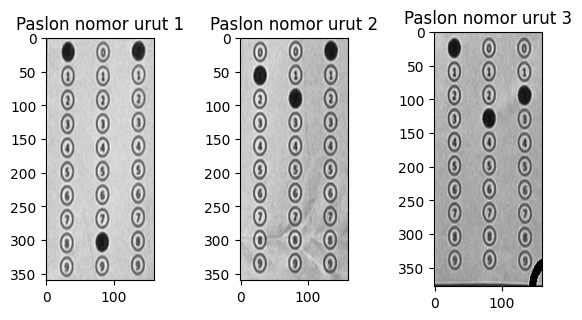

In [35]:
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(calon1, cv2.COLOR_BGR2RGB))
plt.title('Paslon nomor urut 1')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(calon2, cv2.COLOR_BGR2RGB))
plt.title('Paslon nomor urut 2')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(calon3, cv2.COLOR_BGR2RGB))
plt.title('Paslon nomor urut 3')

plt.subplots_adjust(wspace=0.8)
plt.show()

In [37]:
num1 = count_votes(calon1)
num2 = count_votes(calon2)
num3 = count_votes(calon3)

print("Jumlah suara masing-masing paslon")
print("Paslon nomor urut 1:", num1)
print("Paslon nomor urut 2:", num2)
print("Paslon nomor urut 3:", num3)

Jumlah suara masing-masing paslon
Paslon nomor urut 1: 80
Paslon nomor urut 2: 120
Paslon nomor urut 3: 32
